# [Ex05] 6. 영화리뷰 텍스트 감성분석하기

- [ ] 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. -> 모델 3가지 이상
- [ ] gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. -> 자체학습 임베딩과 사전학습 임베딩 비교분석
- [ ] 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. -> 정확도 85%이상

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
import keras
import tensorflow as tf
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from sklearn.model_selection import train_test_split
from gensim.models.keyedvectors import Word2VecKeyedVectors
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D

---
## 1) 데이터 준비와 확인

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("train:", train_data.shape)
print("test:", test_data.shape)
train_data.head()

train: (150000, 3)
test: (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


---
## 2)데이터 로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    ## 중복제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    ## 결측 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    ## 사전 word to index 구성  ==> train 데이터로 
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print(len(X_train))
print(len(X_test))

146182
49157


In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
# X_train = pad_sequences(X_train, maxlen=max_len)
# X_test = pad_sequences(X_test, maxlen=max_len)

---
## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문자 ㅇ길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41


In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(
    X_train,
    value=word_to_index["<PAD>"],
    padding='pre', # post에 비해 높은 성능을 내는 pre를 사용
    maxlen=maxlen
)

X_test = keras.preprocessing.sequence.pad_sequences(
    X_test,
    value=word_to_index["<PAD>"],
    padding='pre', # post에 비해 높은 성능을 내는 pre를 사용
    maxlen=maxlen
)

In [11]:
print(len(X_train[0]))
print(len(X_train[1]))

41
41


---
## 4) 모델 구성 및 validation set 구성

In [12]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
remain_X_train = X_train[10000:]  
remain_y_train = y_train[10000:]

print(remain_X_train.shape)
print(remain_y_train.shape)

(136182, 41)
(136182,)


In [13]:
max_len=41

In [14]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 30  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [15]:
# 모델 1 : LSTM
model = Sequential()
model.add(Embedding(input_dim=len(word_to_index), output_dim=128, input_length=max_len))
model.add(LSTM(32))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# 모델 훈련
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,300,881
Trainable params: 1,300,881
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# 모델 2 gru(32) -> dense(8)
gru_model = Sequential()
gru_model.add(Embedding(input_dim=len(word_to_index)+1, output_dim=100, input_length=X_train.shape[1]))
gru_model.add(GRU(32))
gru_model.add(Dense(8, activation='sigmoid'))
gru_model.add(Dense(1, activation='sigmoid'))

# GRU 모델 훈련
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 100)           1000100   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,013,237
Trainable params: 1,013,237
Non-trainable params: 0
_________________________________________________________________


In [18]:
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen, trainable=True))  
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 



# CNN 모델 훈련
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 30)            300000    
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            3376      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [20]:
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

---
## 5) 모델 훈련

In [21]:
# LSTM 모델 훈련
history_lstm = model.fit(remain_X_train, remain_y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
2128/2128 [==============================] - 14s 5ms/step - loss: 0.3925 - accuracy: 0.8304 - val_loss: 0.3250 - val_accuracy: 0.8576
Epoch 2/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2930 - accuracy: 0.8774 - val_loss: 0.3114 - val_accuracy: 0.8676
Epoch 3/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2489 - accuracy: 0.8991 - val_loss: 0.3259 - val_accuracy: 0.8657
Epoch 4/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2132 - accuracy: 0.9158 - val_loss: 0.3395 - val_accuracy: 0.8626
Epoch 5/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.1822 - accuracy: 0.9300 - val_loss: 0.3560 - val_accuracy: 0.8603
Epoch 6/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.1552 - accuracy: 0.9420 - val_loss: 0.3974 - val_accuracy: 0.8582
Epoch 7/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.1312 - accuracy: 0.9526 - val_loss: 0.4235 - val_ac

In [22]:
model_results = model.evaluate(X_test,  y_test, verbose=2)

print(model_results)

1537/1537 - 3s - loss: 0.5473 - accuracy: 0.8499
[0.5472921133041382, 0.8499094843864441]


In [23]:
# GRU 모델 훈련
history_gru = gru_model.fit(remain_X_train, remain_y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
2128/2128 [==============================] - 11s 5ms/step - loss: 0.3901 - accuracy: 0.8288 - val_loss: 0.3347 - val_accuracy: 0.8569
Epoch 2/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.3059 - accuracy: 0.8737 - val_loss: 0.3124 - val_accuracy: 0.8625
Epoch 3/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2652 - accuracy: 0.8919 - val_loss: 0.3141 - val_accuracy: 0.8651
Epoch 4/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2315 - accuracy: 0.9073 - val_loss: 0.3312 - val_accuracy: 0.8648
Epoch 5/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.2000 - accuracy: 0.9222 - val_loss: 0.3492 - val_accuracy: 0.8603
Epoch 6/10
2128/2128 [==============================] - 10s 5ms/step - loss: 0.1716 - accuracy: 0.9348 - val_loss: 0.3724 - val_accuracy: 0.8547
Epoch 7/10
2128/2128 [==============================] - 10s 4ms/step - loss: 0.1466 - accuracy: 0.9452 - val_loss: 0.4151 - val_ac

In [24]:
gru_results = gru_model.evaluate(X_test,  y_test, verbose=2)

print(gru_results)

1537/1537 - 3s - loss: 0.5135 - accuracy: 0.8440
[0.5135223269462585, 0.8439896702766418]


In [25]:
# CNN 모델 훈련
history_cnn = cnn_model.fit(remain_X_train, remain_y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
2128/2128 [==============================] - 10s 4ms/step - loss: 0.3824 - accuracy: 0.8234 - val_loss: 0.3220 - val_accuracy: 0.8617
Epoch 2/10
2128/2128 [==============================] - 8s 4ms/step - loss: 0.2820 - accuracy: 0.8825 - val_loss: 0.3207 - val_accuracy: 0.8632
Epoch 3/10
2128/2128 [==============================] - 8s 4ms/step - loss: 0.2202 - accuracy: 0.9126 - val_loss: 0.3383 - val_accuracy: 0.8576
Epoch 4/10
2128/2128 [==============================] - 8s 4ms/step - loss: 0.1606 - accuracy: 0.9416 - val_loss: 0.4051 - val_accuracy: 0.8505
Epoch 5/10
2128/2128 [==============================] - 8s 4ms/step - loss: 0.1176 - accuracy: 0.9589 - val_loss: 0.4592 - val_accuracy: 0.8507
Epoch 6/10
2128/2128 [==============================] - 8s 4ms/step - loss: 0.0916 - accuracy: 0.9684 - val_loss: 0.5393 - val_accuracy: 0.8436
Epoch 7/10
2128/2128 [==============================] - 9s 4ms/step - loss: 0.0739 - accuracy: 0.9748 - val_loss: 0.5844 - val_accuracy

In [26]:
model_results = model.evaluate(X_test,  y_test, verbose=2)

print(gru_results)

1537/1537 - 3s - loss: 0.5473 - accuracy: 0.8499
[0.5135223269462585, 0.8439896702766418]


---
## 6) Loss, Accuarcy 그래프 시각화

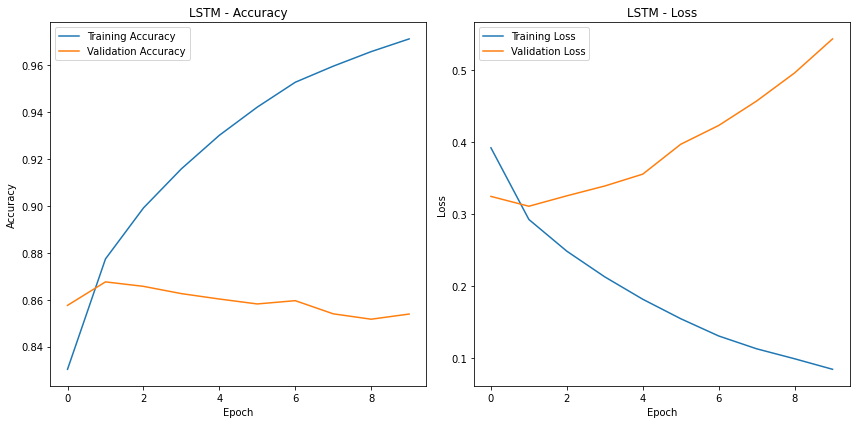

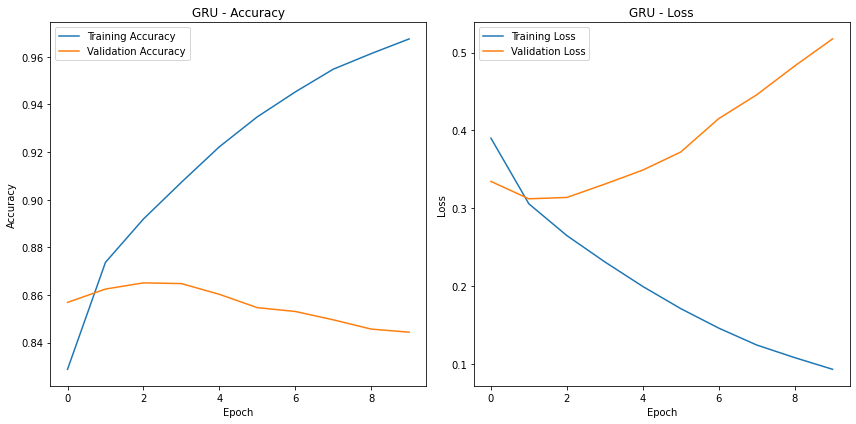

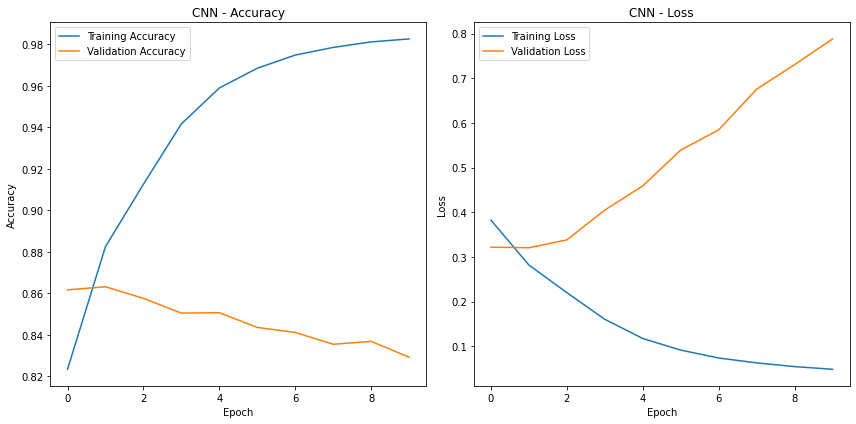

In [27]:
import matplotlib.pyplot as plt


# 그래프 시각화
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Accuracy 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 각 모델의 훈련 결과 시각화
plot_history(history_lstm, 'LSTM')
plot_history(history_gru, 'GRU')
plot_history(history_cnn, 'CNN')


---
## 7) 학습된 Embedding 레이어 분석

In [28]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


## + 한국어 Word2Vec 임베딩 활용해서 성능 개선

In [29]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [30]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [31]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [32]:
# model4 : embedding -> gru(32) -> dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(
    vocab_size, 
    word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen, 
    trainable=True
)(inputs)
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.GRU(64, return_sequences=False)(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model4 = keras.Model(inputs, outputs)

In [33]:
model4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 41, 64)            31872     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0     

In [34]:
# 학습의 진행
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(remain_X_train,
                    remain_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 6s 11ms/step - loss: 0.4981 - accuracy: 0.7613 - val_loss: 0.3826 - val_accuracy: 0.8261
Epoch 2/20
266/266 [==============================] - 2s 9ms/step - loss: 0.3625 - accuracy: 0.8476 - val_loss: 0.3358 - val_accuracy: 0.8498
Epoch 3/20
266/266 [==============================] - 2s 9ms/step - loss: 0.3189 - accuracy: 0.8687 - val_loss: 0.3210 - val_accuracy: 0.8564
Epoch 4/20
266/266 [==============================] - 2s 9ms/step - loss: 0.2927 - accuracy: 0.8818 - val_loss: 0.3121 - val_accuracy: 0.8622
Epoch 5/20
266/266 [==============================] - 2s 9ms/step - loss: 0.2734 - accuracy: 0.8903 - val_loss: 0.3177 - val_accuracy: 0.8609
Epoch 6/20
266/266 [==============================] - 2s 9ms/step - loss: 0.2570 - accuracy: 0.8980 - val_loss: 0.3179 - val_accuracy: 0.8652
Epoch 7/20
266/266 [==============================] - 2s 9ms/step - loss: 0.2390 - accuracy: 0.9066 - val_loss: 0.3301 - val_accuracy: 0.8652
Epoch

In [35]:
results4 = model4.evaluate(X_test,  y_test, verbose=2)

print(results4)

1537/1537 - 4s - loss: 0.8525 - accuracy: 0.8508
[0.8524659872055054, 0.8508452773094177]


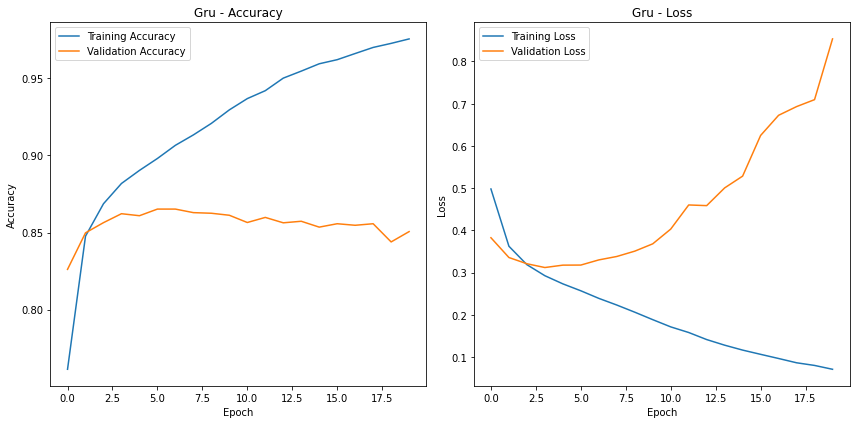

In [36]:
plot_history(history4, 'Gru')